# Set your path here

In [1]:
input_path = "../input/" + "richters-predictor-modeling-earthquake-damage/"
output_path = ""

# Environment
if you use **Kaggle**, you only need to turn on GPU, no need to install any packages.  
Otherwise, you should install the following packages:  
!pip3 install xgboost  
!pip3 install lightgbm  
!pip3 install catboost  
!pip3 install vecstack  

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

# importing voting classifier
#ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
#stacking
from vecstack import stacking

from sklearn.metrics import f1_score, make_scorer

In [3]:
def get_feature_importance(X_train, model, figure_path):
    useful_features = [c for c in X_train.columns if c not in ("building_id", "kfold", "damage_grade")]
    
    fimportance = model.feature_importances_
    fimportance_df = pd.DataFrame()
    fimportance_df.loc[:, "f_imp"] = fimportance
    fimportance_df.loc[:, "col"] = X_train[useful_features].columns
    fimportance_df.sort_values(by="f_imp", ascending=False, inplace=True)
    fig, ax = plt.subplots(1, 1, figsize=(12, 24))
    ax = sns.barplot(x="f_imp", y="col",
                    data=fimportance_df,
                    palette="GnBu_d")
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.set_xlabel("Feature Importance in %", fontsize=24)
    ax.set_ylabel("Features", fontsize=24)
    path = (output_path + "feature_importance_"+figure_path+".png")
    fig.savefig(path, bbox_inches='tight')
    
    results = list(zip(X_train, model.feature_importances_))
    importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
    importance = importance.sort_values(by="Importance", ascending=False)
    
    return importance

# Load Data

In [4]:
df_train = pd.read_csv(input_path + 'train_values.csv')
train_labels = pd.read_csv(input_path + 'train_labels.csv')

# Preprocessing for Cross-validation

In [5]:
df_train['damage_grade'] = train_labels['damage_grade']

df_train["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train)):
    df_train.loc[valid_indicies, "kfold"] = fold

df_train.to_csv(output_path + "train_folds.csv", index=False)

# Reload Data

In [6]:
df = pd.read_csv(output_path + "train_folds.csv", index_col='building_id')
df_test = pd.read_csv(input_path + 'test_values.csv', index_col='building_id')

## Data Analysis

In [7]:
df.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

In [8]:
df.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,kfold
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272,1.999992
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814,1.414219
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000


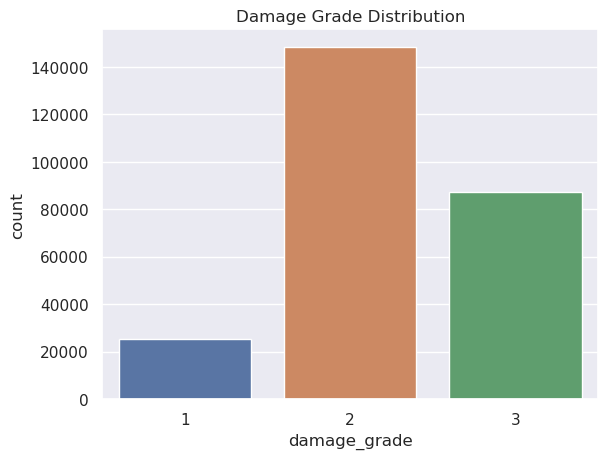

In [9]:
sns.countplot(x="damage_grade", data=df)
plt.title("Damage Grade Distribution")
plt.show()

## Correlations

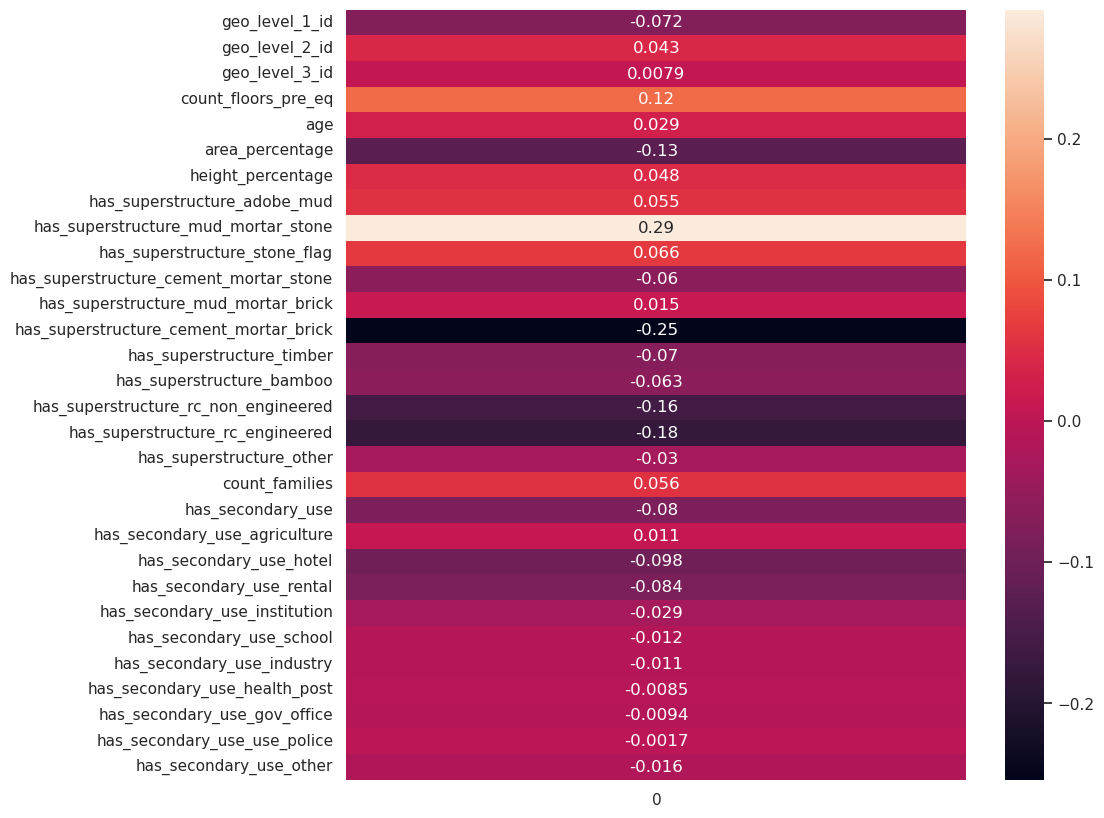

In [10]:
useful_features = [c for c in df.columns if c not in ("building_id", "kfold", "damage_grade")]

plt.figure(figsize=(10,10))
correlations = df[useful_features].corrwith(df["damage_grade"])
sns.heatmap(pd.DataFrame(correlations), annot=True)
plt.show()

# Feature Engineering

## Numerical Columns 

In [11]:
numerical_cols = [c for c in useful_features if df[c].dtype == 'int64'
                 and not c.startswith('has') and not c.startswith('geo')]

print("numerical features:")
print(numerical_cols)

numerical features:
['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']


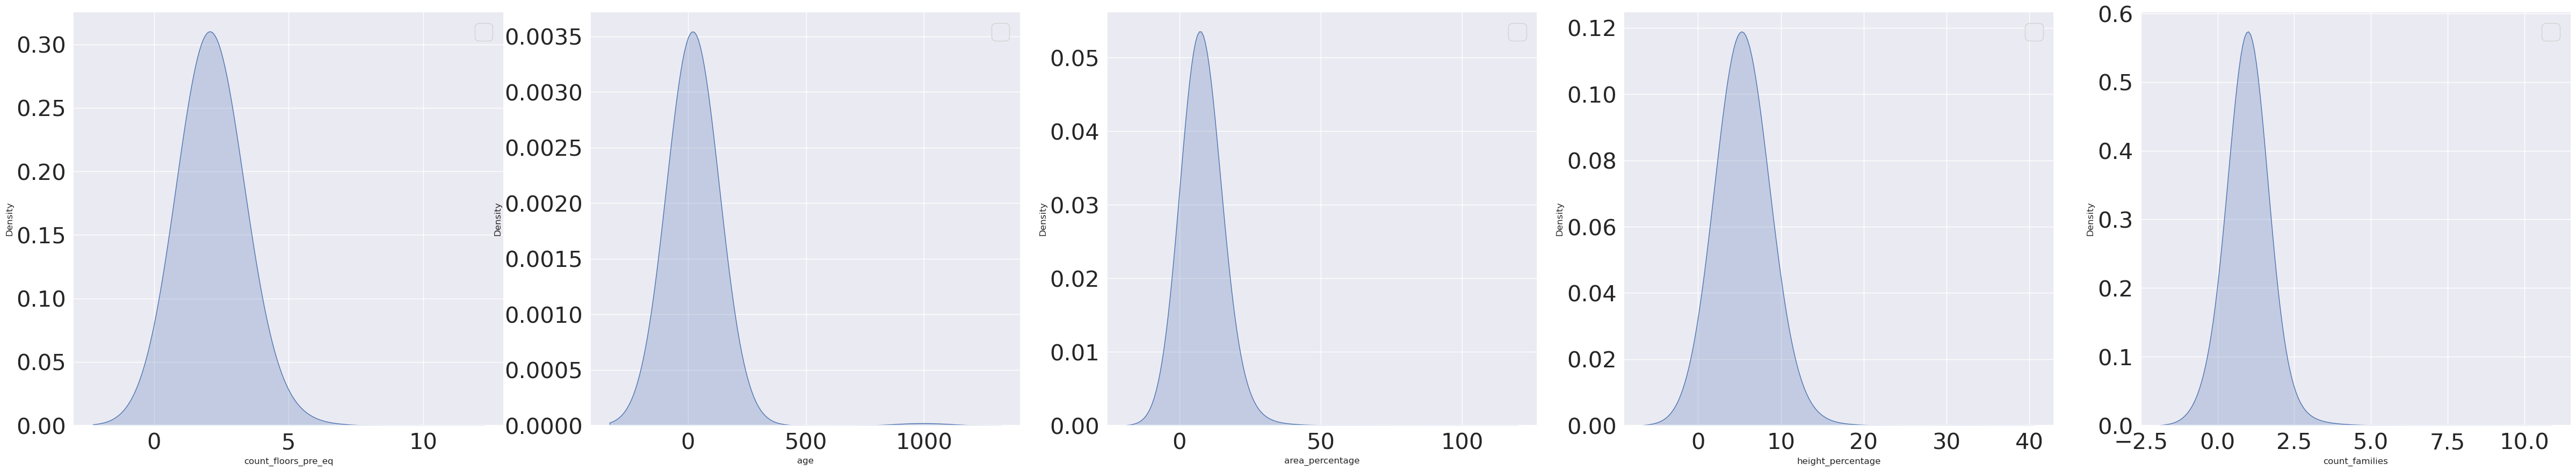

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(60, 10))
num_var_df = df.loc[:, numerical_cols]
for number, ax in enumerate(axs.flat):
    sns.kdeplot(num_var_df.iloc[:, number], bw_method=1.5, ax=ax,
                fill=True, cbar="GnBu_d")
    ax.tick_params(axis="both", which="major", labelsize=30)
    ax.legend(fontsize=30, loc="upper right")
fig_path = (output_path + "numerical_columns_before_preprocessing.png")
fig.savefig(fig_path, bbox_inches="tight")

### Log Transformation

In [13]:
for col in df[numerical_cols].columns:
    df[col] = np.log1p(df[col])
    df_test[col] = np.log1p(df_test[col])

### Standard Scaler

In [14]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

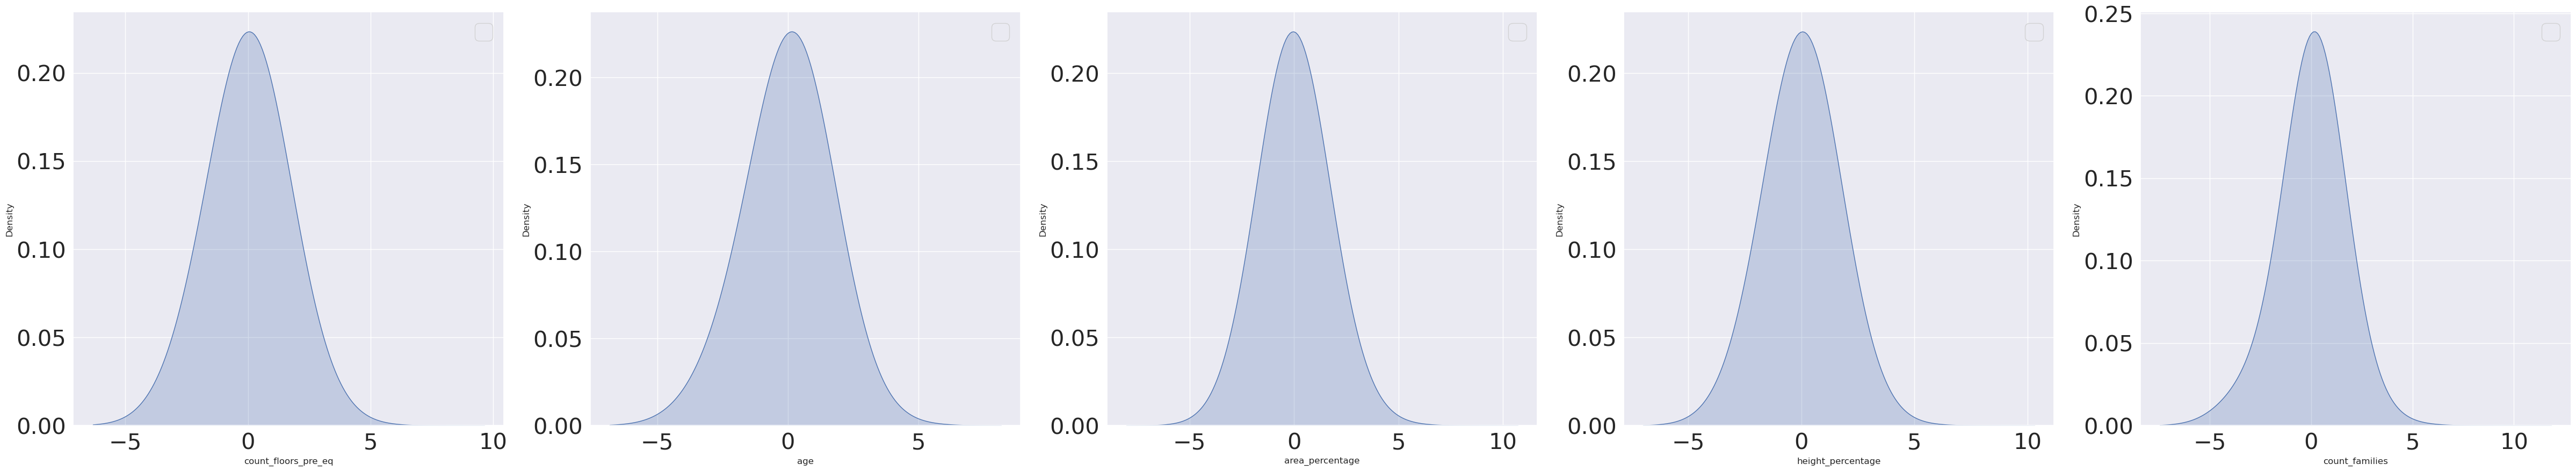

In [15]:
num_var_df = df.loc[:, numerical_cols]
# Plot the newly created plot log variables
fig, axs = plt.subplots(1, 5, figsize=(60, 10))
for number, ax in enumerate(axs.flat):
    sns.kdeplot(num_var_df.iloc[:, number], bw_method=1.5, ax=ax,
               fill=True, cbar="GnBu_d")
    ax.tick_params(axis="both", which="major", labelsize=30)
    ax.legend(fontsize=30, loc="upper right")
fig_path = (output_path + "numerical_columns_after_preprocessing.png")
fig.savefig(fig_path, bbox_inches="tight")

## Object columns

In [16]:
object_cols = [c for c in useful_features if df[c].dtype == 'object']

print("object features:")
print(object_cols)

object features:
['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


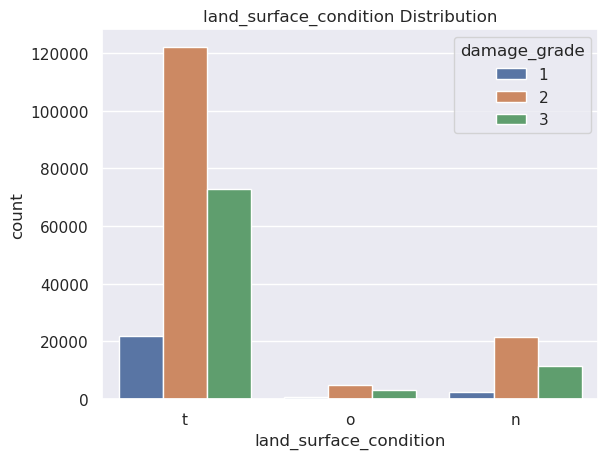

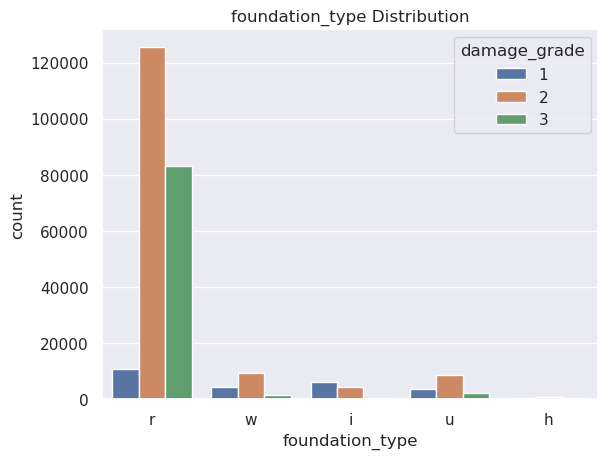

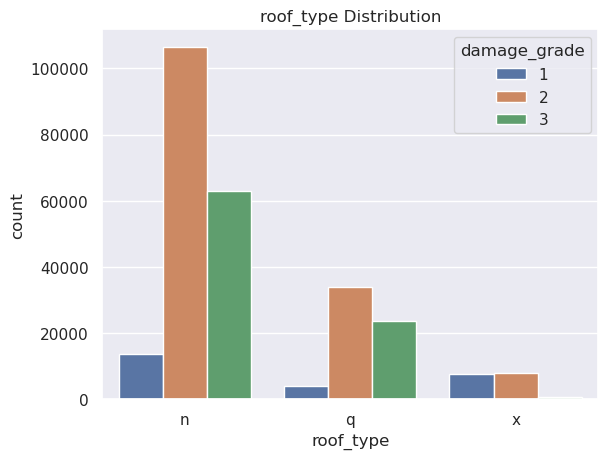

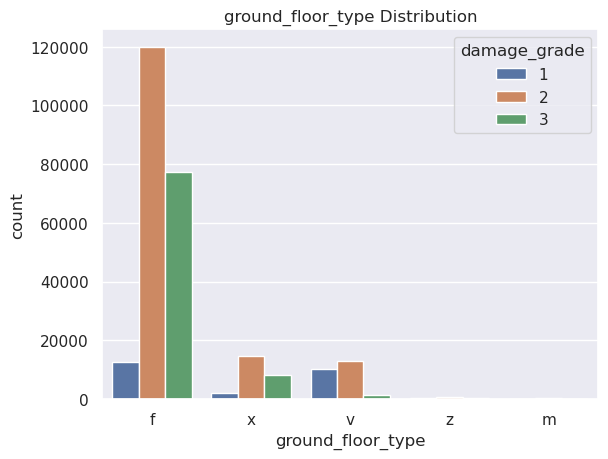

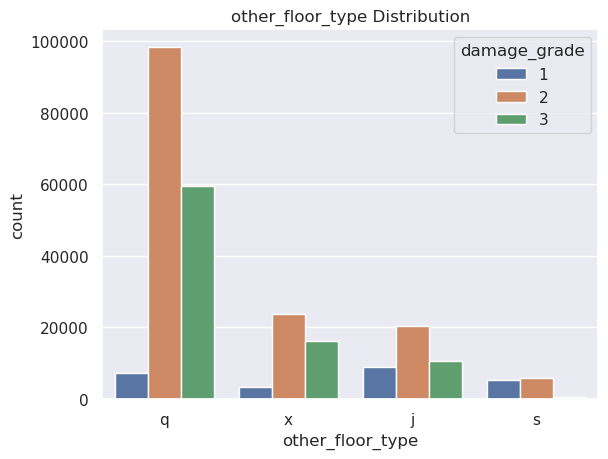

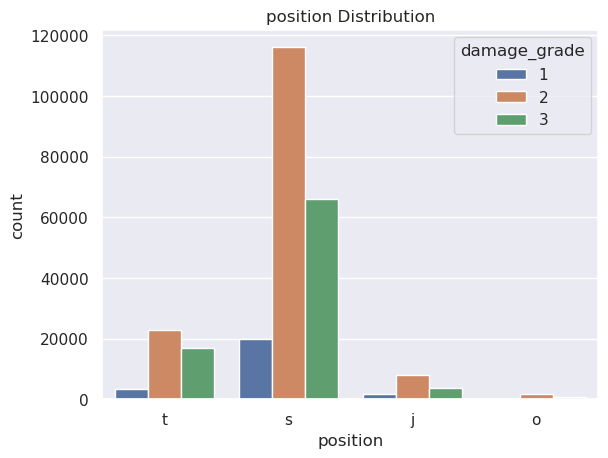

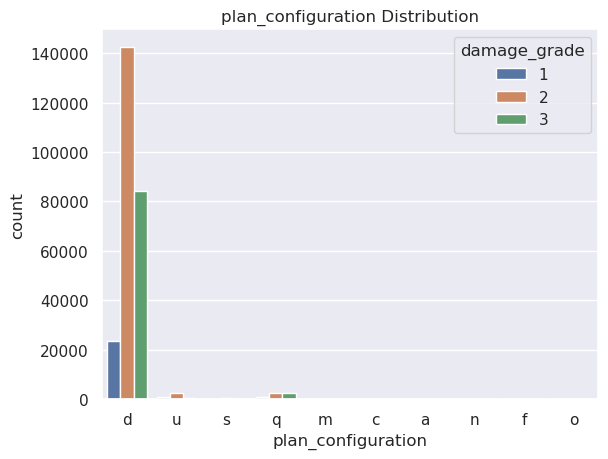

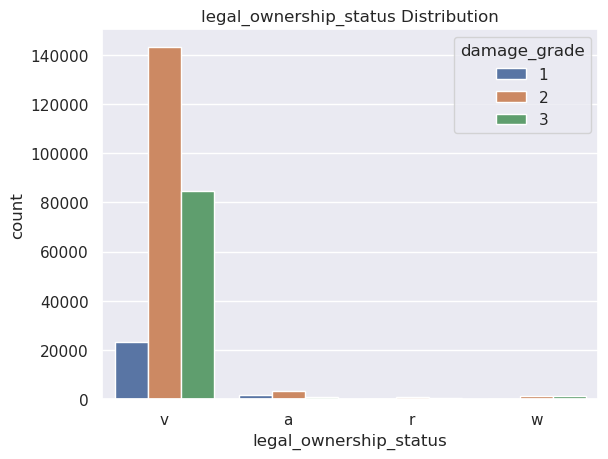

In [17]:
for col in object_cols:
    sns.countplot(x = df[col], hue = df["damage_grade"])
    plt.title(col + " Distribution")
    plt.show()

In [18]:
foundations = df.foundation_type.unique()
floors = df.ground_floor_type.unique()
damages = df.damage_grade.unique()

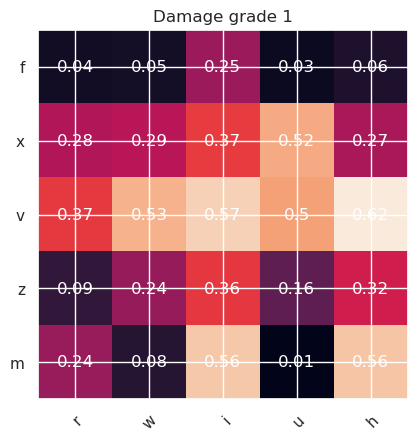

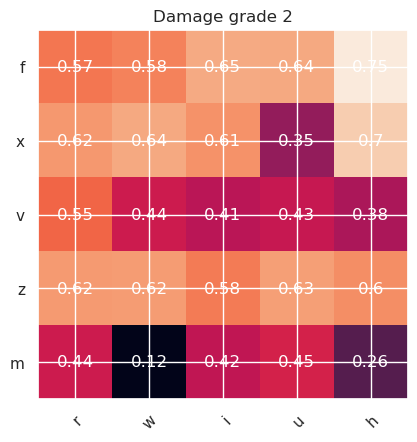

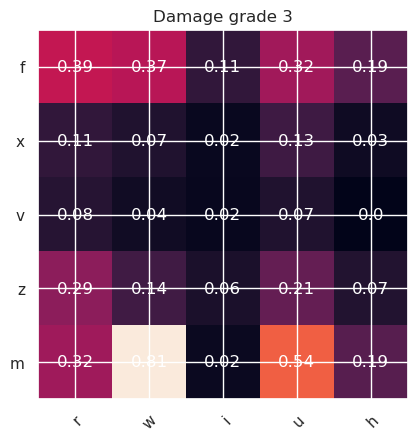

In [19]:
for damage in range(1,4):
    total = df.shape[0]
    cond_matrix = []

    for found in foundations:
        row = []
        for fl in floors:
            cond = sum(np.logical_and(df_train.foundation_type == found,df_train.ground_floor_type == fl))
            joint = sum(np.logical_and(np.logical_and(df_train.foundation_type == found,df_train.ground_floor_type == fl), df_train.damage_grade == damage))
            p_cond = cond / total
            p_joint = joint / total
            p_conditional = p_joint / p_cond
            row.append(p_conditional)
        cond_matrix.append(row)
    cond_matrix = np.array(cond_matrix)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cond_matrix)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(foundations)), labels=foundations)
    ax.set_yticks(np.arange(len(floors)), labels=floors)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    for i in range(len(floors)):
        for j in range(len(foundations)):
            text = ax.text(j, i, cond_matrix.round(2)[i, j],
                           ha="center", va="center", color="w")
    ax.set_title("Damage grade {}".format(damage))

### Feature Combination

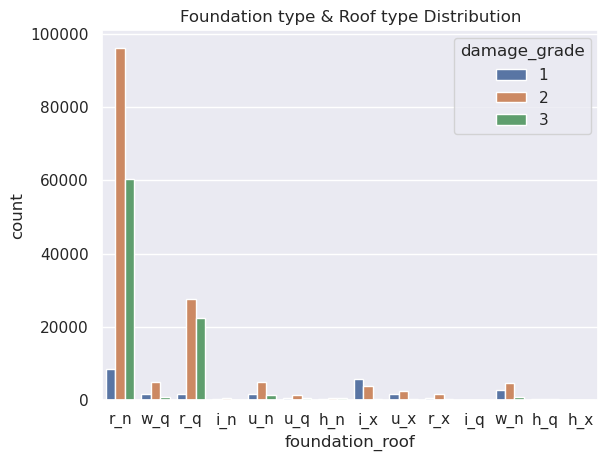

In [20]:
df["foundation_roof"] = (df.foundation_type.astype(str)+ "_"+ df.roof_type.astype(str))
df_test["foundation_roof"] = (df_test.foundation_type.astype(str)+ "_"+ df_test.roof_type.astype(str))

sns.countplot(x = df["foundation_roof"], hue = df["damage_grade"])
plt.title("Foundation type & Roof type Distribution")
plt.show()

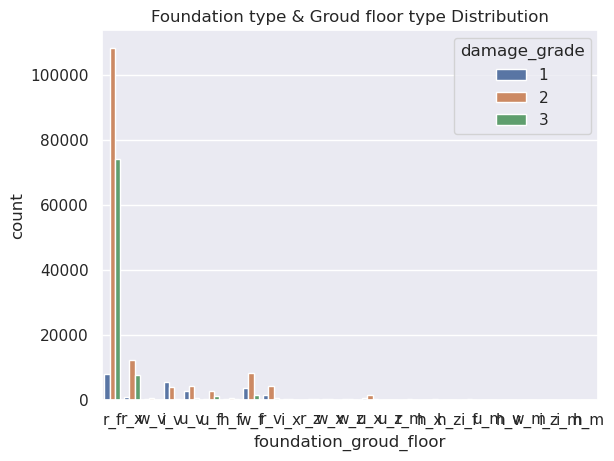

In [21]:
df["foundation_groud_floor"] = (df.foundation_type.astype(str)+ "_"+ df.ground_floor_type.astype(str))
df_test["foundation_groud_floor"] = (df_test.foundation_type.astype(str)+ "_"+ df_test.ground_floor_type.astype(str))

sns.countplot(x = df["foundation_groud_floor"], hue = df["damage_grade"])
plt.title("Foundation type & Groud floor type Distribution")
plt.show()

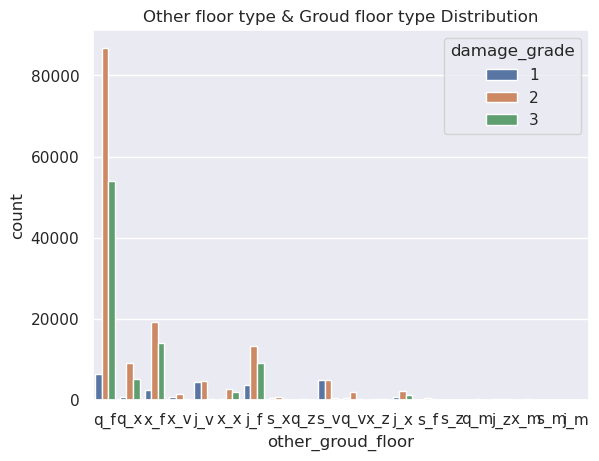

In [22]:
df["other_groud_floor"] = (df.other_floor_type.astype(str)+ "_"+ df.ground_floor_type.astype(str))
df_test["other_groud_floor"] = (df_test.other_floor_type.astype(str)+ "_"+ df_test.ground_floor_type.astype(str))

sns.countplot(x = df["other_groud_floor"], hue = df["damage_grade"])
plt.title("Other floor type & Groud floor type Distribution")
plt.show()

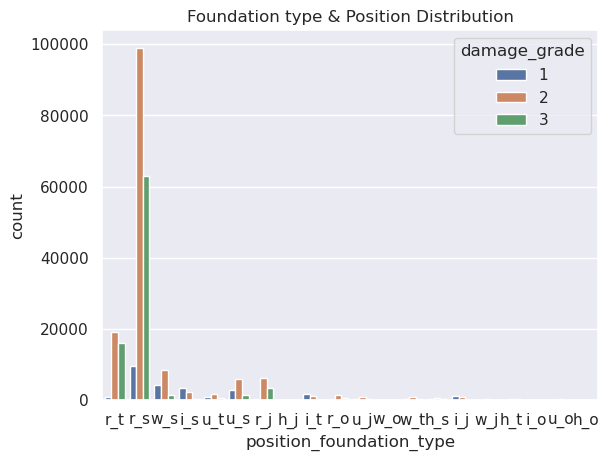

In [23]:
df["position_foundation_type"] = (df.foundation_type.astype(str)+ "_"+ df.position.astype(str))
df_test["position_foundation_type"] = (df_test.foundation_type.astype(str)+ "_"+ df_test.position.astype(str))

sns.countplot(x = df["position_foundation_type"], hue = df["damage_grade"])
plt.title("Foundation type & Position Distribution")
plt.show()

### Ordinal Encoding

In [24]:
ordinal_df = df.copy()
ordinal_df_test = df_test.copy()

ordinal_encoder = preprocessing.OrdinalEncoder()

ordinal_df[object_cols] = ordinal_encoder.fit_transform(ordinal_df[object_cols])
ordinal_df_test[object_cols] = ordinal_encoder.transform(ordinal_df_test[object_cols])

### One-hot Encoding

In [25]:
ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown="ignore")

df_ohe = df.copy()
df_test_ohe = df_test.copy()

df_ohe_cols = ohe.fit_transform(df_ohe[object_cols])
df_test_ohe_cols = ohe.transform(df_test_ohe[object_cols])
    
df_ohe_cols = pd.DataFrame(df_ohe_cols, columns=[f"ohe_{i}" for i in range(df_ohe_cols.shape[1])])
df_test_ohe_cols = pd.DataFrame(df_test_ohe_cols, columns=[f"ohe_{i}" for i in range(df_test_ohe_cols.shape[1])])
    
df_ohe = pd.concat([df_ohe, df_ohe_cols], axis=1)
df_test_ohe = pd.concat([df_test_ohe, df_test_ohe_cols], axis=1)
    
df_ohe = df_ohe.drop(object_cols, axis=1)
df_test_ohe = df_test_ohe.drop(object_cols, axis=1)

### Target Encoding

In [26]:
useful_features = [c for c in df.columns if c not in ("building_id", "kfold", "damage_grade")]
object_cols = [c for c in useful_features if df[c].dtype == 'object']

for col in object_cols: 
    feat_mean = df.groupby(col)["damage_grade"].agg("mean")
    feat_mean = feat_mean.to_dict()
    df.loc[:, f"tar_enc_{col}_mean"] = df[col].map(feat_mean)
    df_test.loc[:, f"tar_enc_{col}_mean"] = df_test[col].map(feat_mean)

df = df.drop(columns = object_cols)
df_test = df_test.drop(columns = object_cols)

## PCA

In [27]:
## try to use pca to select features 
## it prints out the top 15 important features
from sklearn.decomposition import PCA


# Create PCA object and fit to data
pca = PCA()
pca.fit(df)

# Determine number of principal components to keep
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)
num_components = np.argmax(cumulative_var_ratio >= 0.95) + 1

# Use selected number of components to transform data
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(df)


# Get the loadings of each principal component on each original feature
loadings = pca.components_

# Show the most important original features in each principal component
for i in range(num_components):
    component = loadings[i]
    top_features = sorted(range(len(component)), key=lambda k: abs(component[k]), reverse=True)[:15]
    print("Top features in principal component {}: {}".format(i+1, top_features))

Top features in principal component 1: [2, 1, 0, 6, 3, 8, 11, 4, 30, 7, 20, 9, 5, 34, 19]


## PCA explain
In this example, the PCA object is created and fitted to the input data X. The explained_variance_ratio_ attribute of the PCA object is used to calculate the cumulative explained variance of the principal components. The number of principal components to keep is determined by selecting the minimum number of components that explain at least 95% of the variance in the data. Finally, the input data X is transformed using the selected number of principal components, resulting in a reduced set of features stored in X_pca.
In this example, the loadings variable contains the loadings of each principal component on each original feature. The for loop iterates over each principal component, and the sorted function is used to find the top five original features with the highest absolute value of the loading in that component. The results are printed out to the console.

## Geo Level: Target Encoding

In [28]:
geo_level_cols = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]
for col in geo_level_cols: 
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        xtrain = df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)
        feat = xtrain.groupby(col)["damage_grade"].agg("mean")
        feat = feat.to_dict()
        xvalid.loc[:, f"tar_enc_{col}_mean"] = xvalid[col].map(feat)
        temp_df.append(xvalid)
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    temp_test_feat /= 5
    df_test.loc[:, f"tar_enc_{col}_mean"] = temp_test_feat
    df = pd.concat(temp_df)
    
    feat_std = df.groupby(col)["damage_grade"].agg("std")
    feat_std = feat_std.to_dict()
    df.loc[:, f"tar_enc_{col}_std"] = df[col].map(feat_std)
    df_test.loc[:, f"tar_enc_{col}_std"] = df_test[col].map(feat_std)
    
    feat_count = df.groupby(col)["damage_grade"].agg("count")
    feat_count = feat_count.to_dict()
    df.loc[:, f"tar_enc_{col}_count"] = df[col].map(feat_count)
    df_test.loc[:, f"tar_enc_{col}_count"] = df_test[col].map(feat_count)

    

df = df.drop(columns = geo_level_cols)
df_test = df_test.drop(columns = geo_level_cols)

In [29]:
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
print("Columns with missing value:")
print(cols_with_missing)

Columns with missing value:
['tar_enc_geo_level_2_id_mean', 'tar_enc_geo_level_2_id_std', 'tar_enc_geo_level_3_id_mean', 'tar_enc_geo_level_3_id_std']


# Model

## Train test split

In [30]:
useful_features = [c for c in df.columns if c not in ("building_id", "kfold", "damage_grade")]

X = df[useful_features].copy()
y = pd.DataFrame(df.loc[:, 'damage_grade'] - 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
df_test = df_test[useful_features]

## Random Forest

In [32]:
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=200, 
    max_depth=10,
    n_jobs=4)

## XGBoost

In [33]:
xgb_model = xgb.XGBClassifier(
    random_state=1, 
    n_estimators = 1000, 
    learning_rate = 0.1, 
    max_depth = 5, 
    tree_method='gpu_hist', 
    gpu_id=0, 
    predictor="gpu_predictor")

In [34]:
xgb_model.fit(X_train, y_train)

xgb_preds_train = xgb_model.predict(X_train)
print(f1_score(y_train, xgb_preds_train, average='micro'))

xgb_preds_valid = xgb_model.predict(X_valid)
print(f1_score(y_valid, xgb_preds_valid, average='micro'))

xgb_preds_test = xgb_model.predict(df_test)

0.7946901381427476
0.7609792597993132


,Feature,Importance
45,tar_enc_geo_level_3_id_mean,0.164711
35,tar_enc_foundation_roof_mean,0.088964
36,tar_enc_foundation_groud_floor_mean,0.082244
46,tar_enc_geo_level_3_id_std,0.080492
31,tar_enc_other_floor_type_mean,0.043156
42,tar_enc_geo_level_2_id_mean,0.041383
37,tar_enc_other_groud_floor_mean,0.039870
5,has_superstructure_mud_mortar_stone,0.035383
9,has_superstructure_cement_mortar_brick,0.031902
1,age,0.027347


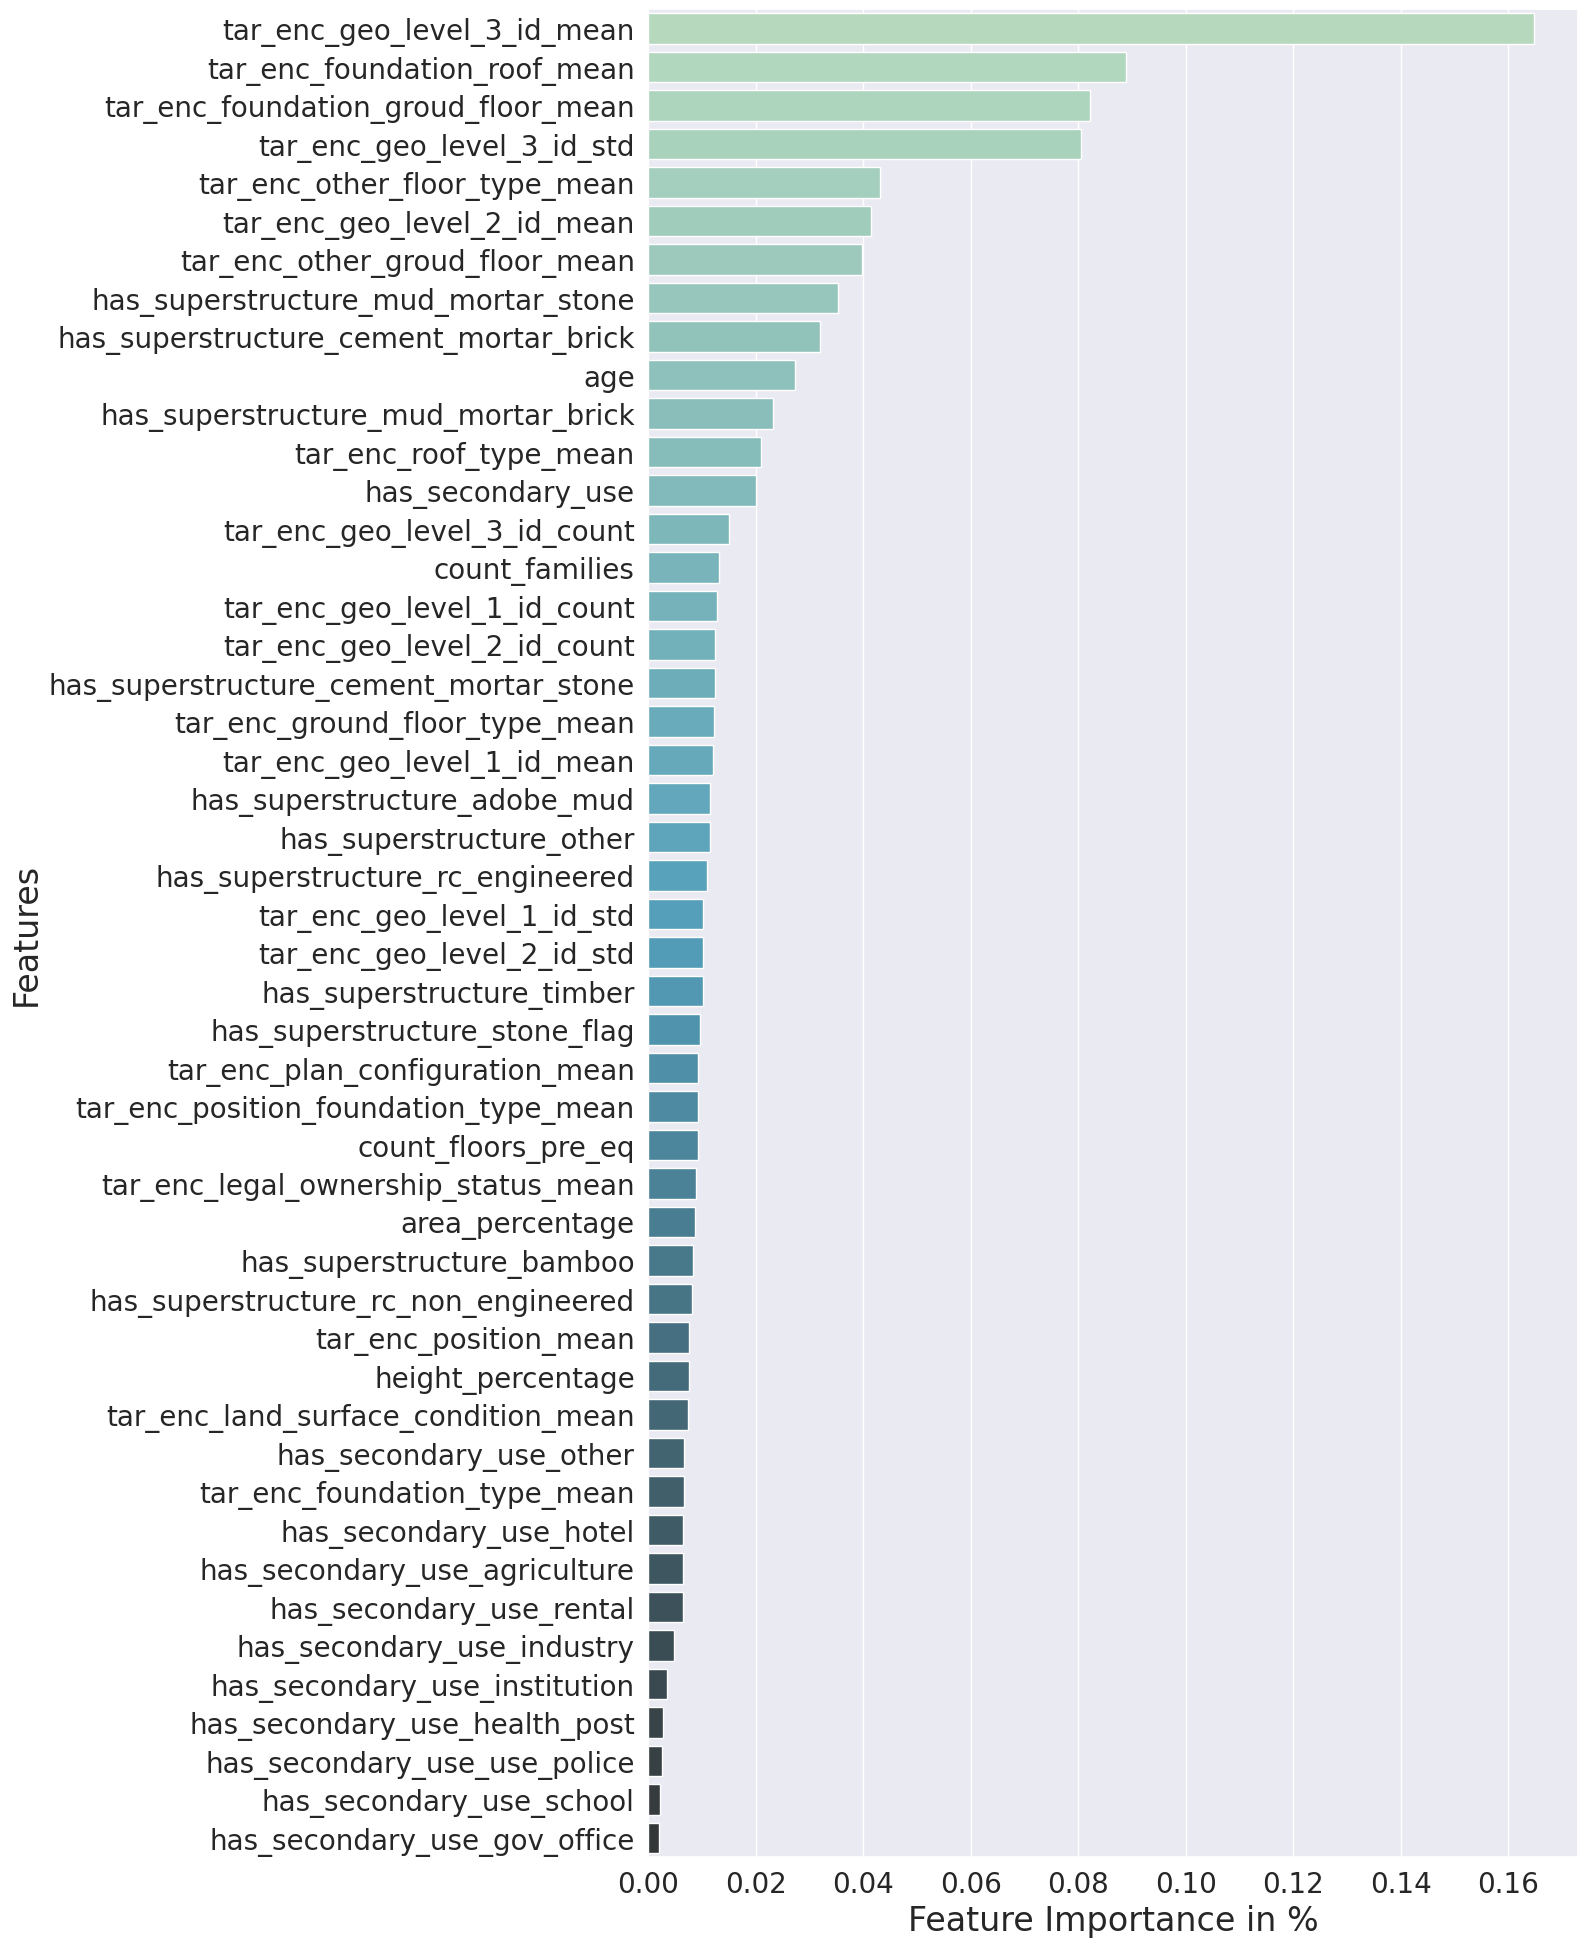

In [35]:
importance_list = get_feature_importance(X_train, xgb_model, "xgb_")
importance_list.head(15)

## CatBoost

In [36]:
cb_model = CatBoostClassifier(
    random_state = 1,
    n_estimators=1500,
    learning_rate = 0.1,
    l2_leaf_reg = 10,
    max_depth = 7, 
    class_weights = [1, 2, 2.5],
    loss_function = 'MultiClass',
    task_type="GPU",
    devices='0:1')
cb_model.fit(X_train, y_train, verbose=False)

In [37]:
cb_preds_train = cb_model.predict(X_train)
print(f1_score(y_train, cb_preds_train, average='micro'))

cb_preds_valid = cb_model.predict(X_valid)
print(f1_score(y_valid, cb_preds_valid, average='micro'))

cb_preds_test = cb_model.predict(df_test)

0.7899079048349962
0.7561635425260451


## LightGBM

In [38]:
gbm_model = lgb.LGBMClassifier(
    random_state=33,
    n_estimators=1400,
    num_leaves=230,
    learning_rate=0.1,
    lambda_l2=5,
    max_bin=90,
    max_depth=30,
    is_unbalance=True, 
    device="GPU")

In [39]:
gbm_model.fit(X_train, y_train)

gbm_preds_train = gbm_model.predict(X_train)
print(f1_score(y_train, gbm_preds_train, average='micro'))

gbm_preds_valid = gbm_model.predict(X_valid)
print(f1_score(y_valid, gbm_preds_valid, average='micro'))

gbm_preds_test = gbm_model.predict(df_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
0.9629796623177282
0.7536693463287351


## Max Voting

In [40]:
final_model = VotingClassifier(
    estimators=[('lgbm', gbm_model), ('xgb', xgb_model), ('cat', cb_model)], voting='soft')

final_model.fit(X_train, np.ravel(y_train))

[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
0:	learn: 1.0108813	total: 13.9ms	remaining: 20.8s
1:	learn: 0.9420049	total: 25.6ms	remaining: 19.1s
2:	learn: 0.8869242	total: 37.2ms	remaining: 18.6s
3:	learn: 0.8407294	total: 48.7ms	remaining: 18.2s
4:	learn: 0.8023904	total: 61ms	remaining: 18.2s
5:	learn: 0.7699675	total: 72.8ms	remaining: 18.1s
6:	learn: 0.7423135	total: 84.3ms	remaining: 18s
7:	learn: 0.7182110	total: 95.9ms	remaining: 17.9s
8:	learn: 0.6975537	total: 107ms	remaining: 17.8s
9:	learn: 0.6797989	total: 119ms	remaining: 17.7s
10:	learn: 0.6642515	total: 131ms	remaining: 17.7s
11:	learn: 0.6502612	total: 142ms	remaining: 17.6s
12:	learn: 0.6380156	total: 154ms	remaining: 17.6s
13:	learn: 0.6273293	total: 166ms	remaining: 17.6s
14:	learn: 0.6180159	total: 177ms	remaining: 17.6s
15:	learn: 0.6094618	total: 189ms	remaining: 17.6s
16:	learn: 0.6019820	total: 201ms	remaining: 17.5s
17:	learn: 0.5954082	total: 216ms	remai

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(device='GPU', is_unbalance=True,
                                             lambda_l2=5, max_bin=90,
                                             max_depth=30, n_estimators=1400,
                                             num_leaves=230, random_state=33)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            ev...
                                            learning_rate=0.1, max_bin=256,
                                            max_cat_to_onehot=4,

In [41]:
final_model_train = final_model.predict(X_train)
print(f1_score(y_train, final_model_train, average='micro'))

final_model_valid = final_model.predict(X_valid)
print(f1_score(y_valid, final_model_valid, average='micro'))

final_model_test = final_model.predict(df_test)

0.8750527628549502
0.7619001937798583


## Stacking 1

In [42]:
estimators = [
     ('gbm', gbm_model),
     ('xgb', xgb_model)
]
xgb_estimator = xgb.XGBClassifier(random_state=1, learning_rate = 0.1, n_estimators = 1000, max_depth = 5, tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
stack_model = StackingClassifier(estimators=estimators,
                            final_estimator=xgb_estimator,
                            cv=5)

In [43]:
stack_model.fit(X_train, y_train)
stack_model_preds_train = stack_model.predict(X_train)
print(f1_score(y_train, stack_model_preds_train, average='micro'))

stack_model_preds_valid = stack_model.predict(X_valid)
print(f1_score(y_valid, stack_model_preds_valid, average='micro'))

stack_model_preds_test = stack_model.predict(df_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
0.8465752110514198
0.7610943765468813


In [44]:
# putting all base model objects in one list
all_models = [xgb_model, gbm_model]
 
# computing the stack features
s_train, s_test = stacking(all_models, X_train, np.ravel(y_train),
                           df_test, regression=False, n_folds=4,shuffle=True,verbose=False)

[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


In [45]:
# initializing the second-level model
stack_model = xgb.XGBClassifier(random_state=1, learning_rate = 0.1, n_estimators = 1000, max_depth = 5, tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")
 
# fitting the second level model with stack features
stack_model.fit(s_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=1, reg_alpha=0, ...)

In [46]:
stack_model_test = stack_model.predict(s_test)

## Stacking 2

In [47]:
estimators = [
     ('cat', cb_model),
     ('xgb', xgb_model)
]
lgclassifier = LogisticRegression(random_state=123)
sclf = StackingClassifier(estimators=estimators,
                            final_estimator=lgclassifier,
                            cv=5)

In [48]:
sclf.fit(X_train, y_train)
sclf_preds_train = sclf.predict(X_train)
print(f1_score(y_train, sclf_preds_train, average='micro'))

sclf_preds_valid = sclf.predict(X_valid)
print(f1_score(y_valid, sclf_preds_valid, average='micro'))

sclf_preds_test = sclf.predict(df_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 1.0108812	total: 13.7ms	remaining: 20.5s
1:	learn: 0.9420051	total: 25.4ms	remaining: 19s
2:	learn: 0.8869242	total: 37.2ms	remaining: 18.6s
3:	learn: 0.8407293	total: 49ms	remaining: 18.3s
4:	learn: 0.8023907	total: 60.9ms	remaining: 18.2s
5:	learn: 0.7699676	total: 73ms	remaining: 18.2s
6:	learn: 0.7423134	total: 84.8ms	remaining: 18.1s
7:	learn: 0.7182110	total: 96.3ms	remaining: 18s
8:	learn: 0.6975536	total: 108ms	remaining: 17.9s
9:	learn: 0.6797989	total: 119ms	remaining: 17.8s
10:	learn: 0.6642516	total: 131ms	remaining: 17.8s
11:	learn: 0.6502614	total: 143ms	remaining: 17.7s
12:	learn: 0.6380155	total: 154ms	remaining: 17.7s
13:	learn: 0.6273292	total: 166ms	remaining: 17.6s
14:	learn: 0.6180159	total: 177ms	remaining: 17.6s
15:	learn: 0.6094619	total: 189ms	remaining: 17.5s
16:	learn: 0.6019820	total: 201ms	remaining: 17.5s
17:	learn: 0.5954082	total: 217ms	remaining: 17.9s
18:	learn: 0.5892762	total: 229ms	remaining: 17.9s
19:	learn: 0.5839350	total: 241ms	remaini

## Submission

In [49]:
my_predictions = final_model_test + 1

In [50]:
submission_format = pd.read_csv(input_path +  'submission_format.csv', index_col='building_id')

In [51]:
my_submission = pd.DataFrame(data=my_predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.to_csv(output_path + 'submission.csv')

In [52]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3
